In [1]:
#In the name of God

student_id = 401210923
student_name = "Navid Farahani"

print("your student id:", student_id)
print("your name:", student_name)
import numpy as np
import torch


import torch.nn as nn
import torch.nn.functional as F
import os

from torch.utils.data import random_split
import matplotlib.pyplot as plt
from torch.utils.data.dataloader import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader


from transformers import GPT2LMHeadModel, GPT2Tokenizer


your student id: 401210923
your name: Navid Farahani


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**قسمت الف**


In [3]:
# Load the pre-trained GPT2 model and tokenizer for Persian language

# Selecting the tokenizer for tokenizing
tokenizer = GPT2Tokenizer.from_pretrained('HooshvareLab/gpt2-fa')
tokenizer.pad_token=tokenizer.eos_token# Now the model will be able to detect end of sentences!

dir='drive/MyDrive/Q3 Materials/'

# reading from the text file and using \n for finding the hemistiches

with open(dir+'ferdousi.txt', 'r', encoding='utf-8') as f:
    text = f.read()
    sentences = text.strip().split('\n')
    # we consider 2 hemistiches and then predict the next t=2 hemistiches
    pairs = [(sentences[i]+' '+sentences[i+1],sentences[i+2]+' '+sentences[i+3]) for i in range(2, (len(sentences)-1)//2, 2)]# range 2, because the first sentence is English!


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/728 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/875k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/14.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/104 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.75M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/808 [00:00<?, ?B/s]

In [12]:
print(len(pairs[0][0]))# So, for example, we have 48 vowels for the couplet( every couplet is made up of two hemistiches)
print(pairs[0][0])# The first couplet
print(pairs[0][1])# The second couplet

48
به نام خداوند جان و خرد کزین برتر اندیشه برنگذرد
خداوند نام و خداوند جای خداوند روزی ده رهنمای


In [5]:

# Split all the couplets to train dataset and test dataset
train_couplets = pairs[:int(len(pairs)*0.8)]
test_couplets = pairs[int(len(pairs)*0.8):]


**قسمت ب**

In [6]:



def to_device(data, device):
    # for every batch, we pass the data to the current device.
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)



class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl=dl
        self.device=device

    def __iter__(self):
        #For every batch, we pass it to the current device.
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

# Selecting the current device
if torch.cuda.is_available():
      device=torch.device('cuda')
else:
      device=torch.device('cpu')


# Tokenize the train and test pairs for every first and second couplet of train and test datasets, we consider the length 80 for tokens
train_first_token = [tokenizer.encode_plus(pair[0], add_special_tokens=True,padding='max_length',max_length=80,return_tensors='pt',truncation=True) for pair in train_couplets]
train_second_token = [tokenizer.encode_plus(pair[1], add_special_tokens=True,padding='max_length',max_length=80,return_tensors='pt',truncation=True) for pair in train_couplets]
test_first_token = [tokenizer.encode_plus(pair[0], add_special_tokens=True,padding='max_length',max_length=80,return_tensors='pt',truncation=True) for pair in test_couplets]
test_second_token = [tokenizer.encode_plus(pair[1], add_special_tokens=True,padding='max_length',max_length=80,return_tensors='pt',truncation=True) for pair in test_couplets]


#### Dataset and Dataloader

class CoupletsDatasetProducer(Dataset):
  def __init__(self,first,second):
    self.first=first# first couplet
    self.second=second# second couplet

  def __getitem__(self,index):
    # We have 3 important variables, input_model,input_attention and output_model
    # We send input_model which is the first couplet and receive output_model which is the second couplet
    # Also, we need to define input_attention
    # because the sizes of tokens are not necessary equal, so we need to tell the model to pay attention to non zero tokens
    # Thus we use  .attention_mask to solve this issue.

    input_tokens = self.first[index]
    output_tokens = self.second[index]
    input_model = input_tokens.input_ids
    input_attention = input_tokens.attention_mask
    output_model=output_tokens.input_ids
    return input_model, input_attention, output_model

  def __len__(self):
    return len(self.first)


train_dataset = CoupletsDatasetProducer(train_first_token,train_second_token)
test_dataset = CoupletsDatasetProducer(test_first_token,test_second_token)

train_dl = DataLoader(train_dataset,batch_size=32,shuffle=False)
test_dl = DataLoader(test_dataset,batch_size=32,shuffle=False)

train_dl=DeviceDataLoader(train_dl,device)
test_dl=DeviceDataLoader(test_dl,device)

In [7]:
print(len(train_dataset))
print(train_dataset[15])
print(test_dataset[8])


19843
(tensor([[ 1175,   520, 21337, 12841,  2964,  2969,   798,   902,  5170, 15233,
          1257,     5,     5,     5,     5,     5,     5,     5,     5,     5,
             5,     5,     5,     5,     5,     5,     5,     5,     5,     5,
             5,     5,     5,     5,     5,     5,     5,     5,     5,     5,
             5,     5,     5,     5,     5,     5,     5,     5,     5,     5,
             5,     5,     5,     5,     5,     5,     5,     5,     5,     5,
             5,     5,     5,     5,     5,     5,     5,     5,     5,     5,
             5,     5,     5,     5,     5,     5,     5,     5,     5,     5]]), tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]]), tensor([[ 1175,   399,   610,  3953, 27093,   312,  2964,   323,   696,   391,


**قسمت ج**

In [10]:

model=GPT2LMHeadModel.from_pretrained('HooshvareLab/gpt2-fa')

for param in model.parameters():
    param.requires_grad=True

model.to(device)
optimizer=torch.optim.Adam(model.parameters(),lr=1e-4)
num_epochs=5
losses=[]
for epoch in range(num_epochs):
    i=0
    model.train()
    for inputs,attention,labels in train_dl:

        model=model.to(device)
        i=i+1

        inputs=inputs.to(device)
        attention=attention.to(device)
        labels=labels.to(device)


        outputs = model(inputs.to(torch.long),attention_mask=attention,labels=inputs.to(torch.long))# passing input tokens, attention mask and labels to the model for calculating the loss but it
        # seems that if we pass the inputs as labels the loss, and also the generated text will be better!

        loss=outputs.loss# I asked from TA and it seems that we should use the output of the model to find the loss!!
        losses.append(loss.item())


        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if i %20==0:

            input_sentence= tokenizer.batch_decode(inputs[0].to('cpu'), skip_special_tokens=True)# Making the sentence from tokens again!
            model.eval()
            tokenized_input=tokenizer.encode_plus(input_sentence,return_tensors='pt',max_length=80).to(device)# Constructing the tokens of input of the model and attention
            # Now we use model.generate to generate new sentences, we should pass it input tokens, and attention mask, all other parameters are arbitrary but we fine tuned them.

            out_model=model.generate(tokenized_input['input_ids'],do_sample=True,max_length=128, temperature=0.999, attention_mask=tokenized_input['attention_mask'])

            print("Real sentence is:\n",input_sentence)
            print("Generated sentence is:\n",[tokenizer.decode(out_model[i],skip_special_tokens=True) for i in range(len(out_model))])


            print("Epoch is:",epoch+1,"\nIteration is:",i,"      Loss is:",loss.item(),)





Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['خورشگر بدیشان بزی چند و میش سپردی و صحرا نهادند پیش']
Generated sentence is:
 ['']
Epoch is: 1 
Iteration is: 20       Loss is: 1.6294913291931152


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['سزد گر بمانیم هر دو دژم کزین سان پدر کرد بر ما ستم']
Generated sentence is:
 ['ى با سخن گفت یکی از جهان بخت']
Epoch is: 1 
Iteration is: 40       Loss is: 1.1919894218444824


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['سپاهی بدین رزمگاه آمدیم نه بر آرزو کینه خواه آمدیم']
Generated sentence is:
 ['ش بود گفت جهان را شاه و تخت شاهی کرد و تاج سر ضحاک']
Epoch is: 1 
Iteration is: 60       Loss is: 1.1525086164474487


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['بدیدند مر پهلوان را پگاه وزان جایگه برگرفتند راه']
Generated sentence is:
 [' ای که از سر نیزه یک کوه باشد شیر هم بر چون دل بجوی']
Epoch is: 1 
Iteration is: 80       Loss is: 1.0667824745178223


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['چو از خوان خسرو بپرداختند به تخت دگر جای می ساختند']
Generated sentence is:
 ['']
Epoch is: 1 
Iteration is: 100       Loss is: 1.0331223011016846


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['شب آمد جهان سر به سر تیره گشت مرا بازو از کوفتن خیره گشت']
Generated sentence is:
 ['اید که با سر راه راه رفتن با پای تخت خواب همی شد ز شاه چین به زمان']
Epoch is: 1 
Iteration is: 120       Loss is: 1.0037771463394165


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['ز گرد سواران در آن پهن دشت زمین شش شد و آسمان گشت هشت']
Generated sentence is:
 ['گان را به زمین زد هر چه که تو خواستند به دستان تاختند']
Epoch is: 1 
Iteration is: 140       Loss is: 1.0339171886444092


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['پراگنده در پادشاهی سوار همانا که هستند سیصدهزار']
Generated sentence is:
 [' اندر آید کیستی یکی به تو بدار بر تو بداد از او']
Epoch is: 1 
Iteration is: 160       Loss is: 1.0183181762695312


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['خبر شد به شاه هماور ازین که رستم نهادست بر رخش زین']
Generated sentence is:
 ['گان باید به آن گروه داد از جنگ و تیمار بر دیوان گردان']
Epoch is: 1 
Iteration is: 180       Loss is: 0.8959699273109436


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['نهانی بسازیم بهتر بود خرد داشتن کار مهتر بود']
Generated sentence is:
 ['ش ز گنج و ز بیابان آید بی نیاز ز شکار']
Epoch is: 1 
Iteration is: 200       Loss is: 1.0052489042282104


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['همی ماند رستم ازو در شگفت ز پیگارش اندازه ها برگرفت']
Generated sentence is:
 ['م که این کار و این آیین را دیده گفت من چه کنم']
Epoch is: 1 
Iteration is: 220       Loss is: 0.9644824862480164


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['ز هر در سخن چون بدین گونه گشت بر آتش یکی را بباید گذشت']
Generated sentence is:
 ['وان مرا بدین که در سراسر مرا بباید کنم روی']
Epoch is: 1 
Iteration is: 240       Loss is: 0.9637762308120728


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['ز کاووس وز خام گفتار او ز خوی بد و رای و پیگار او']
Generated sentence is:
 [' را از با او نگه داشت به تندی و با مهر و خردان پرامید']
Epoch is: 1 
Iteration is: 260       Loss is: 0.9111366868019104


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['هرآنکس که او از در کار بود بدان مرز با او سزاوار بود']
Generated sentence is:
 [' همه با او به هم رای پر شتابنده ست و پر ز خواب']
Epoch is: 1 
Iteration is: 280       Loss is: 0.8842714428901672


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['فرنگیس رانیز خواهند کشت مکن هیچ گونه برین کار پشت']
Generated sentence is:
 ['']
Epoch is: 1 
Iteration is: 300       Loss is: 0.9314584136009216


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['بران ابر باران خجسته سروش به گودرز گفتی که بگشای گوش']
Generated sentence is:
 ['وی برکشید تا به خاک اندر آورد همی تا به پیش او که بر خاک پر از خاک انداختی']
Epoch is: 1 
Iteration is: 320       Loss is: 0.9061257839202881


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['چو خورشید برزد سر از برج شیر سپهر اندر آورد شب را به زیر']
Generated sentence is:
 ['']
Epoch is: 1 
Iteration is: 340       Loss is: 0.9036731719970703


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['درفشی کجا شیر پیکر بزر که گودرز کشواد دارد بسر']
Generated sentence is:
 ['']
Epoch is: 1 
Iteration is: 360       Loss is: 0.9666824340820312


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['بیامد باسپ اندر آورد پای بکردار باد اندر آمد ز جای']
Generated sentence is:
 [' نام از آن باره رنج بی نیاز شد چون دژ و برج و تیغ']
Epoch is: 1 
Iteration is: 380       Loss is: 0.8974145650863647


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['درخشیدن تیغ و ژوپین و خشت تو گفتی شب اندر هوا لاله کشت']
Generated sentence is:
 ['']
Epoch is: 1 
Iteration is: 400       Loss is: 0.8785375952720642


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['چو خاقان بدیدش به بر درگرفت بماند از بر و یال پیران شگفت']
Generated sentence is:
 [' در جنگ بیاراستند که با لشکری جنگست سپاه']
Epoch is: 1 
Iteration is: 420       Loss is: 0.879861056804657


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['نهادند آوردگاهی بزرگ کشانی بیامد بکردار گرگ']
Generated sentence is:
 ['']
Epoch is: 1 
Iteration is: 440       Loss is: 0.916537344455719


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['گریزی بهنگام با سر بجای به از رزم جستن بنام و برای']
Generated sentence is:
 [' ز خون ز پیش او ز من یکی سخن گوست و کردار خون']
Epoch is: 1 
Iteration is: 460       Loss is: 0.8448768258094788


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['بدو گفت کای دیو ناسازگار ببینی کنون گردش روزگار']
Generated sentence is:
 ['وان بگرد شاه بر گرد اندر بداد و سپاه اندر آورد ز گردان']
Epoch is: 1 
Iteration is: 480       Loss is: 0.8740618824958801


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['اگر هست خود جای گفتار نیست ولیکن شنیدن چو دیدار نیست']
Generated sentence is:
 [' و دست از رنج اندرون همه ازو بی یال باد و بی بند']
Epoch is: 1 
Iteration is: 500       Loss is: 0.9375551342964172


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['گرانمایه هفت اسب با کاروان یکی رخش و دیگر نشست گوان']
Generated sentence is:
 [' و ز آفرین که دل بسته از دور و در تو دارم ز گردان تو']
Epoch is: 1 
Iteration is: 520       Loss is: 0.9064702987670898


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['چو پیران بدید آن سپاه بزرگ بخون تشنه هر یک بکردار گرگ']
Generated sentence is:
 ['ده ز گردان سپاه و ز گردان لشکر بدو شد به سپاه']
Epoch is: 1 
Iteration is: 540       Loss is: 0.8620152473449707


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['بلشکر بفرمود پس پهلوان که بیدار باشید و روشن روان']
Generated sentence is:
 [' آن گونه لشکر را بتوران بکین بدگمان نیو']
Epoch is: 1 
Iteration is: 560       Loss is: 0.819929301738739


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['که پشت همه شهر توران بدوست چو روی تو بیند بدردش پوست']
Generated sentence is:
 [' ازان کس را که این داستان سر از تخم تو ناید با کس']
Epoch is: 1 
Iteration is: 580       Loss is: 0.820182204246521


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['بزنهار بر ما کنون عار نیست سپاهست بسیار و سالار نیست']
Generated sentence is:
 ['']
Epoch is: 1 
Iteration is: 600       Loss is: 0.8117125034332275


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['دمادم فرستد سلیح و سپاه خورش را شتر نگسلاند ز راه']
Generated sentence is:
 [' نامداران مرد و با هوش و مهرش بر شاه گستهم']
Epoch is: 1 
Iteration is: 620       Loss is: 0.8599324226379395


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['خورشگر بدیشان بزی چند و میش سپردی و صحرا نهادند پیش']
Generated sentence is:
 [' نه کسی که ببایست همی گفت بدشت به کین همی']
Epoch is: 2 
Iteration is: 20       Loss is: 0.951231837272644


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['سزد گر بمانیم هر دو دژم کزین سان پدر کرد بر ما ستم']
Generated sentence is:
 [' ازو بر به تخت بر تخت برآمد چو نام شاه بر نهفت بر تخت گاه']
Epoch is: 2 
Iteration is: 40       Loss is: 0.8539609313011169


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['سپاهی بدین رزمگاه آمدیم نه بر آرزو کینه خواه آمدیم']
Generated sentence is:
 [' و شاه ز ما یکی دو دیده بان و ز ما آن سه شاه را']
Epoch is: 2 
Iteration is: 60       Loss is: 0.8031047582626343


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['بدیدند مر پهلوان را پگاه وزان جایگه برگرفتند راه']
Generated sentence is:
 ['گان بدو بر نهادند سوی کاخ سام نهادند']
Epoch is: 2 
Iteration is: 80       Loss is: 0.85399329662323


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['چو از خوان خسرو بپرداختند به تخت دگر جای می ساختند']
Generated sentence is:
 [' و ز دور و ز راه که رای او همه پیش ایشان به شادی و گژ']
Epoch is: 2 
Iteration is: 100       Loss is: 0.807558536529541


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['شب آمد جهان سر به سر تیره گشت مرا بازو از کوفتن خیره گشت']
Generated sentence is:
 ['وان آمد به فرمان شاه جهان را یکی شد رای او']
Epoch is: 2 
Iteration is: 120       Loss is: 0.7857290506362915


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['ز گرد سواران در آن پهن دشت زمین شش شد و آسمان گشت هشت']
Generated sentence is:
 [' اندر هر گونه جنگ و رزم و بخت تو دانی همی با من چه جنگ']
Epoch is: 2 
Iteration is: 140       Loss is: 0.7962175607681274


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['پراگنده در پادشاهی سوار همانا که هستند سیصدهزار']
Generated sentence is:
 [' از بر پشت کوه و در روی خویش برآویختند ز روی']
Epoch is: 2 
Iteration is: 160       Loss is: 0.7944096326828003


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['خبر شد به شاه هماور ازین که رستم نهادست بر رخش زین']
Generated sentence is:
 [' اندر زمان شاه که جنگ را بی تو کنم و بر دل و زبان']
Epoch is: 2 
Iteration is: 180       Loss is: 0.700926661491394


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['نهانی بسازیم بهتر بود خرد داشتن کار مهتر بود']
Generated sentence is:
 ['و و فرهاد ز لشکر یکی انجمن کرد به شاه که از لشکر یک و یک کلاه']
Epoch is: 2 
Iteration is: 200       Loss is: 0.8285191059112549


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['همی ماند رستم ازو در شگفت ز پیگارش اندازه ها برگرفت']
Generated sentence is:
 [' و رکیب و بازو به جنگ اندرش از تو به بالا دارد و نام']
Epoch is: 2 
Iteration is: 220       Loss is: 0.7928154468536377


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['ز هر در سخن چون بدین گونه گشت بر آتش یکی را بباید گذشت']
Generated sentence is:
 [' و گرسیوز چو از پیش او به تختش برگرفتنش درود']
Epoch is: 2 
Iteration is: 240       Loss is: 0.8158096075057983


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['ز کاووس وز خام گفتار او ز خوی بد و رای و پیگار او']
Generated sentence is:
 [' و زان گونه در جنگ با شاه به هم در جنگ بگفتند که چون خورشید شد به راه']
Epoch is: 2 
Iteration is: 260       Loss is: 0.7469738125801086


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['هرآنکس که او از در کار بود بدان مرز با او سزاوار بود']
Generated sentence is:
 [' و مرد بی گناه به جنگ و گردش نیست یکی نیز نه این نیست']
Epoch is: 2 
Iteration is: 280       Loss is: 0.6904497742652893


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['فرنگیس رانیز خواهند کشت مکن هیچ گونه برین کار پشت']
Generated sentence is:
 ['ش به تخت فروماند سوی رود روانش را به آبنوس']
Epoch is: 2 
Iteration is: 300       Loss is: 0.7902258634567261


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['بران ابر باران خجسته سروش به گودرز گفتی که بگشای گوش']
Generated sentence is:
 ['شان به زرین سپر یکی نامه از اسپ و یکی تاجور بخت']
Epoch is: 2 
Iteration is: 320       Loss is: 0.7665806412696838


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['چو خورشید برزد سر از برج شیر سپهر اندر آورد شب را به زیر']
Generated sentence is:
 [' تا به نزدیک او آید همی تا به ایران کند از برگاه او']
Epoch is: 2 
Iteration is: 340       Loss is: 0.7359452843666077


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['درفشی کجا شیر پیکر بزر که گودرز کشواد دارد بسر']
Generated sentence is:
 [' جهانجوی و باژ دو چشم و ز آب و باژ فرهی']
Epoch is: 2 
Iteration is: 360       Loss is: 0.7952995300292969


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['بیامد باسپ اندر آورد پای بکردار باد اندر آمد ز جای']
Generated sentence is:
 [' لشکر سوی پهلوان آمدند و باز آمدند و باز شتاب']
Epoch is: 2 
Iteration is: 380       Loss is: 0.746341347694397


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['درخشیدن تیغ و ژوپین و خشت تو گفتی شب اندر هوا لاله کشت']
Generated sentence is:
 [' و شاد گشت و بی پدر در تنگ بگذاشت سر']
Epoch is: 2 
Iteration is: 400       Loss is: 0.7131181359291077


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['چو خاقان بدیدش به بر درگرفت بماند از بر و یال پیران شگفت']
Generated sentence is:
 [' و همه دانش جوی که آید زمان و زمان کس درنگ و روز']
Epoch is: 2 
Iteration is: 420       Loss is: 0.7317588329315186


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['نهادند آوردگاهی بزرگ کشانی بیامد بکردار گرگ']
Generated sentence is:
 [' بر خیره نماند از کار او دل پر ز خشم دل اندر افتاد']
Epoch is: 2 
Iteration is: 440       Loss is: 0.776099443435669


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['گریزی بهنگام با سر بجای به از رزم جستن بنام و برای']
Generated sentence is:
 [' از هر کسی که آمد بر شاه چین زمین شد زمین شد به چین']
Epoch is: 2 
Iteration is: 460       Loss is: 0.709636390209198


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['بدو گفت کای دیو ناسازگار ببینی کنون گردش روزگار']
Generated sentence is:
 [' اندر آمد یکی نامه ز لشکر گزین کرد شهریار کلید']
Epoch is: 2 
Iteration is: 480       Loss is: 0.7271691560745239


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['اگر هست خود جای گفتار نیست ولیکن شنیدن چو دیدار نیست']
Generated sentence is:
 ['شان بجوئید روانش ز هر سو که او بود سر بدگشیر']
Epoch is: 2 
Iteration is: 500       Loss is: 0.7997508645057678


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['گرانمایه هفت اسب با کاروان یکی رخش و دیگر نشست گوان']
Generated sentence is:
 ['ده بنزدیک رستم بپای و پای نشسته پر از آفرین و روی']
Epoch is: 2 
Iteration is: 520       Loss is: 0.777234673500061


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['چو پیران بدید آن سپاه بزرگ بخون تشنه هر یک بکردار گرگ']
Generated sentence is:
 [' ازان تخت بر کمر خواستش ز توران گروه را براه خاست']
Epoch is: 2 
Iteration is: 540       Loss is: 0.744576632976532


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['بلشکر بفرمود پس پهلوان که بیدار باشید و روشن روان']
Generated sentence is:
 [' از جنگ جنگ او یکی را نشان پیش اندرون خاک و سنگ']
Epoch is: 2 
Iteration is: 560       Loss is: 0.6838275194168091


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['که پشت همه شهر توران بدوست چو روی تو بیند بدردش پوست']
Generated sentence is:
 [' از من که با بدیشان یکی سوی یزدان کنم بتیران سر']
Epoch is: 2 
Iteration is: 580       Loss is: 0.6890761256217957


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['بزنهار بر ما کنون عار نیست سپاهست بسیار و سالار نیست']
Generated sentence is:
 ['شان زین چنین کرد آفرین که با شاه و نامداران بباد']
Epoch is: 2 
Iteration is: 600       Loss is: 0.6968722939491272


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['دمادم فرستد سلیح و سپاه خورش را شتر نگسلاند ز راه']
Generated sentence is:
 [' او را بباید برین نامداری ازو دور کرد پیش اوی']
Epoch is: 2 
Iteration is: 620       Loss is: 0.7381046414375305


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['خورشگر بدیشان بزی چند و میش سپردی و صحرا نهادند پیش']
Generated sentence is:
 [' آن نامور پهلوان ترکان بپیش جهاندیده بد بر پهلوان روی']
Epoch is: 3 
Iteration is: 20       Loss is: 0.8465195894241333


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['سزد گر بمانیم هر دو دژم کزین سان پدر کرد بر ما ستم']
Generated sentence is:
 [' ز لشکر شاه آمد بزی ز درگاه شاه جهان در صف آمد']
Epoch is: 3 
Iteration is: 40       Loss is: 0.7406039834022522


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['سپاهی بدین رزمگاه آمدیم نه بر آرزو کینه خواه آمدیم']
Generated sentence is:
 ['ندگان وزان نامداران شاه به گرد اندر آورده دشت']
Epoch is: 3 
Iteration is: 60       Loss is: 0.6765069365501404


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['بدیدند مر پهلوان را پگاه وزان جایگه برگرفتند راه']
Generated sentence is:
 [' بر پشت تو با جام زر برمت به ابر اندر کنار او نزیچ']
Epoch is: 3 
Iteration is: 80       Loss is: 0.7401885986328125


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['چو از خوان خسرو بپرداختند به تخت دگر جای می ساختند']
Generated sentence is:
 [' بر من یکی پهلوان به نام به زاری بر زدم تا شب اندر شگفت']
Epoch is: 3 
Iteration is: 100       Loss is: 0.6865419745445251


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['شب آمد جهان سر به سر تیره گشت مرا بازو از کوفتن خیره گشت']
Generated sentence is:
 [' این سخنها را یکی کن که چون بباید کنون شدن پیش دل شادمان']
Epoch is: 3 
Iteration is: 120       Loss is: 0.6730387210845947


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['ز گرد سواران در آن پهن دشت زمین شش شد و آسمان گشت هشت']
Generated sentence is:
 [' بر او بگریست ز درد اندر آورد دم ز درد جگر']
Epoch is: 3 
Iteration is: 140       Loss is: 0.676362156867981


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['پراگنده در پادشاهی سوار همانا که هستند سیصدهزار']
Generated sentence is:
 [' و گورشید روی زمین بر شد زمین بر که هرگز نگردد سرش']
Epoch is: 3 
Iteration is: 160       Loss is: 0.6702861785888672


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['خبر شد به شاه هماور ازین که رستم نهادست بر رخش زین']
Generated sentence is:
 [' و بگرفت بر میان همه جای بیمست و راه دشوار را به پای']
Epoch is: 3 
Iteration is: 180       Loss is: 0.5969928503036499


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['نهانی بسازیم بهتر بود خرد داشتن کار مهتر بود']
Generated sentence is:
 [' از دیو و شیردل و رهی نره شیر دل و رخش و شیر']
Epoch is: 3 
Iteration is: 200       Loss is: 0.7236692309379578


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['همی ماند رستم ازو در شگفت ز پیگارش اندازه ها برگرفت']
Generated sentence is:
 [' و گویم همان گردون به فرمان او سپاهی گران']
Epoch is: 3 
Iteration is: 220       Loss is: 0.6811558604240417


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['ز هر در سخن چون بدین گونه گشت بر آتش یکی را بباید گذشت']
Generated sentence is:
 [' و نکوح و هم خواسته به شاه بدانست زو باز']
Epoch is: 3 
Iteration is: 240       Loss is: 0.7073304653167725


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['ز کاووس وز خام گفتار او ز خوی بد و رای و پیگار او']
Generated sentence is:
 [' و رکیب و از خواسته به نزد فرستاده آمد چو گرد بلند']
Epoch is: 3 
Iteration is: 260       Loss is: 0.6515576243400574


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['هرآنکس که او از در کار بود بدان مرز با او سزاوار بود']
Generated sentence is:
 [' از پدر تو به درگاه من ببار تا به درگاه من بیاید تو']
Epoch is: 3 
Iteration is: 280       Loss is: 0.5889906287193298


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['فرنگیس رانیز خواهند کشت مکن هیچ گونه برین کار پشت']
Generated sentence is:
 [' هم از انجمن که ایدونک پیدا کند پیشم شتاب و کین']
Epoch is: 3 
Iteration is: 300       Loss is: 0.6821014881134033


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['بران ابر باران خجسته سروش به گودرز گفتی که بگشای گوش']
Generated sentence is:
 [' از جهان آفریدش به خنجر یکی اسپ تازی پلنگان ببرد']
Epoch is: 3 
Iteration is: 320       Loss is: 0.642461895942688


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['چو خورشید برزد سر از برج شیر سپهر اندر آورد شب را به زیر']
Generated sentence is:
 [' از جهان آفرین تا چه گوید ز کیخسرو و پیلان و کم گوی']
Epoch is: 3 
Iteration is: 340       Loss is: 0.5985880494117737


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['درفشی کجا شیر پیکر بزر که گودرز کشواد دارد بسر']
Generated sentence is:
 [' از تخت زرین ستای وز گوهر همه جامهٔ یکسر به پهلوی']
Epoch is: 3 
Iteration is: 360       Loss is: 0.6852823495864868


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['بیامد باسپ اندر آورد پای بکردار باد اندر آمد ز جای']
Generated sentence is:
 [' اسپ کم آید ز پشت گراز زرهش ز اسپ و ز پشت']
Epoch is: 3 
Iteration is: 380       Loss is: 0.6227008104324341


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['درخشیدن تیغ و ژوپین و خشت تو گفتی شب اندر هوا لاله کشت']
Generated sentence is:
 [' و با سپاه آرای بلند پذیره شدن را بخواند نام و نشان']
Epoch is: 3 
Iteration is: 400       Loss is: 0.5894540548324585


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['چو خاقان بدیدش به بر درگرفت بماند از بر و یال پیران شگفت']
Generated sentence is:
 [' سنان و سنان و نیزه بچنگ آورید سنان و سپر']
Epoch is: 3 
Iteration is: 420       Loss is: 0.6020216345787048


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['نهادند آوردگاهی بزرگ کشانی بیامد بکردار گرگ']
Generated sentence is:
 [' از جهان آفرین کردگار جهان آفرین را بخواه']
Epoch is: 3 
Iteration is: 440       Loss is: 0.6436536908149719


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['گریزی بهنگام با سر بجای به از رزم جستن بنام و برای']
Generated sentence is:
 [' و مغفرش همه پیش صف برکشیدند چون پر آب تشت']
Epoch is: 3 
Iteration is: 460       Loss is: 0.587343156337738


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['بدو گفت کای دیو ناسازگار ببینی کنون گردش روزگار']
Generated sentence is:
 [' اندر آن لشکر آرایند که با گرز و شمشیر شود کار تنگ']
Epoch is: 3 
Iteration is: 480       Loss is: 0.5922114849090576


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['اگر هست خود جای گفتار نیست ولیکن شنیدن چو دیدار نیست']
Generated sentence is:
 ['دهش چنان داد می و می فگند بنمود یک بانگ خروس']
Epoch is: 3 
Iteration is: 500       Loss is: 0.6614751815795898


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['گرانمایه هفت اسب با کاروان یکی رخش و دیگر نشست گوان']
Generated sentence is:
 [' و بایوان و بنخسر پر شتاب دو دیده و دو لب آب']
Epoch is: 3 
Iteration is: 520       Loss is: 0.6347198486328125


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['چو پیران بدید آن سپاه بزرگ بخون تشنه هر یک بکردار گرگ']
Generated sentence is:
 ['ندهٔ تخت و گنج آراسته دو پهلوان جهاندار']
Epoch is: 3 
Iteration is: 540       Loss is: 0.6324383020401001


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['بلشکر بفرمود پس پهلوان که بیدار باشید و روشن روان']
Generated sentence is:
 ['ش هوش آمد و جنگ بجوشیدش ز پیشم بجنگ آن سر آب']
Epoch is: 3 
Iteration is: 560       Loss is: 0.5637599229812622


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['که پشت همه شهر توران بدوست چو روی تو بیند بدردش پوست']
Generated sentence is:
 ['ش فراوان و گفت کتر کاید این کار از بر تو برفتد زمین']
Epoch is: 3 
Iteration is: 580       Loss is: 0.5644932985305786


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['بزنهار بر ما کنون عار نیست سپاهست بسیار و سالار نیست']
Generated sentence is:
 ['ز و بگرز درفشی بدست یکی باد بر کمان پیش من']
Epoch is: 3 
Iteration is: 600       Loss is: 0.5801974534988403


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['دمادم فرستد سلیح و سپاه خورش را شتر نگسلاند ز راه']
Generated sentence is:
 ['ده همه دشت کرد آفرین که بر داد و دین و راه گریز']
Epoch is: 3 
Iteration is: 620       Loss is: 0.5985130071640015


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['خورشگر بدیشان بزی چند و میش سپردی و صحرا نهادند پیش']
Generated sentence is:
 [' از شاه کیخسرو آمد پدید بر جهانجوی گفت آن بدیز']
Epoch is: 4 
Iteration is: 20       Loss is: 0.7652052640914917


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['سزد گر بمانیم هر دو دژم کزین سان پدر کرد بر ما ستم']
Generated sentence is:
 [' و همیدون یکی تازه هوش آمدند بدوی به راه نیو']
Epoch is: 4 
Iteration is: 40       Loss is: 0.6244162321090698


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['سپاهی بدین رزمگاه آمدیم نه بر آرزو کینه خواه آمدیم']
Generated sentence is:
 ['وید و گفت مر شاه را چو روی سپهدار ایران زمین']
Epoch is: 4 
Iteration is: 60       Loss is: 0.5373409986495972


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['بدیدند مر پهلوان را پگاه وزان جایگه برگرفتند راه']
Generated sentence is:
 ['شی ز جای نشست بسان غرقه به خون بر سهیل گوش']
Epoch is: 4 
Iteration is: 80       Loss is: 0.601915717124939


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['چو از خوان خسرو بپرداختند به تخت دگر جای می ساختند']
Generated sentence is:
 ['ش که بود روزگار که با من چه کرد که چون من شد کهن']
Epoch is: 4 
Iteration is: 100       Loss is: 0.5521008372306824


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['شب آمد جهان سر به سر تیره گشت مرا بازو از کوفتن خیره گشت']
Generated sentence is:
 [' و هم چاره جوی ز راه نیاید به رسم کیان بر تو راه']
Epoch is: 4 
Iteration is: 120       Loss is: 0.5514130592346191


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['ز گرد سواران در آن پهن دشت زمین شش شد و آسمان گشت هشت']
Generated sentence is:
 [' و هر گونه با سپاه برو آفرین کن که با من چه دارند و گاه']
Epoch is: 4 
Iteration is: 140       Loss is: 0.5437865257263184


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['پراگنده در پادشاهی سوار همانا که هستند سیصدهزار']
Generated sentence is:
 [' ز زابلستان چون بهشتی شد ناپدید از ناپدید و ناپدید']
Epoch is: 4 
Iteration is: 160       Loss is: 0.5441493391990662


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['خبر شد به شاه هماور ازین که رستم نهادست بر رخش زین']
Generated sentence is:
 ['ده زو نام او را بخواند که کاووس نام او ماند نه پیلان پرند']
Epoch is: 4 
Iteration is: 180       Loss is: 0.48183658719062805


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['نهانی بسازیم بهتر بود خرد داشتن کار مهتر بود']
Generated sentence is:
 ['ده ز ترکان فرستاده ای چون قارن رزم زن و مرد']
Epoch is: 4 
Iteration is: 200       Loss is: 0.5735780596733093


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['همی ماند رستم ازو در شگفت ز پیگارش اندازه ها برگرفت']
Generated sentence is:
 [' از که چون او شاه کند پر خرد کشته شود رزم شیر']
Epoch is: 4 
Iteration is: 220       Loss is: 0.5513912439346313


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['ز هر در سخن چون بدین گونه گشت بر آتش یکی را بباید گذشت']
Generated sentence is:
 [' و بنمود بسیارش ز کار فرو هشته بر کمربند او']
Epoch is: 4 
Iteration is: 240       Loss is: 0.5750475525856018


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['ز کاووس وز خام گفتار او ز خوی بد و رای و پیگار او']
Generated sentence is:
 [' تو چنین کاو ز من بگذرد نخواهد سپهر و رست و نشیب']
Epoch is: 4 
Iteration is: 260       Loss is: 0.5423420071601868


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['هرآنکس که او از در کار بود بدان مرز با او سزاوار بود']
Generated sentence is:
 [' نره صد اشتر صد اشتر ز یلان هزار ز گرد ز دشت و ز دشت']
Epoch is: 4 
Iteration is: 280       Loss is: 0.46732214093208313


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['فرنگیس رانیز خواهند کشت مکن هیچ گونه برین کار پشت']
Generated sentence is:
 [' ز خواب و شتابش به راه سیاوش یکی نامجوی']
Epoch is: 4 
Iteration is: 300       Loss is: 0.5440937280654907


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['بران ابر باران خجسته سروش به گودرز گفتی که بگشای گوش']
Generated sentence is:
 [' از سر مرد جنگ یکی نیزه و تیغ تیز از میان برگذارد جفت']
Epoch is: 4 
Iteration is: 320       Loss is: 0.488019734621048


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['چو خورشید برزد سر از برج شیر سپهر اندر آورد شب را به زیر']
Generated sentence is:
 [' از اسپ گودرز آمد پدید به کردار شیر افگند و آمد']
Epoch is: 4 
Iteration is: 340       Loss is: 0.4535140097141266


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['درفشی کجا شیر پیکر بزر که گودرز کشواد دارد بسر']
Generated sentence is:
 [' از هر دو نژاد یکی یکی برز دار اندر دلها پر ز داد']
Epoch is: 4 
Iteration is: 360       Loss is: 0.5103021264076233


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['بیامد باسپ اندر آورد پای بکردار باد اندر آمد ز جای']
Generated sentence is:
 [' اسپ جنگ آور اسپ بیژن خرام فغان بر اسپ جنگی فزون']
Epoch is: 4 
Iteration is: 380       Loss is: 0.45718514919281006


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['درخشیدن تیغ و ژوپین و خشت تو گفتی شب اندر هوا لاله کشت']
Generated sentence is:
 [' هم ازان بار آمدش براه پر درد و پر بخت زیر بار']
Epoch is: 4 
Iteration is: 400       Loss is: 0.43114805221557617


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['چو خاقان بدیدش به بر درگرفت بماند از بر و یال پیران شگفت']
Generated sentence is:
 [' و برکش سوی کاسه رود همی رفت تا راه لشکر آردت دور']
Epoch is: 4 
Iteration is: 420       Loss is: 0.446929931640625


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['نهادند آوردگاهی بزرگ کشانی بیامد بکردار گرگ']
Generated sentence is:
 [' برو تا برفت سوی کوه هیونی بکردار گرد سیاه']
Epoch is: 4 
Iteration is: 440       Loss is: 0.4851818382740021


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['گریزی بهنگام با سر بجای به از رزم جستن بنام و برای']
Generated sentence is:
 [' چون او نترسد ز کار ز بیژن همی برخروشد بدگمان']
Epoch is: 4 
Iteration is: 460       Loss is: 0.42803457379341125


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['بدو گفت کای دیو ناسازگار ببینی کنون گردش روزگار']
Generated sentence is:
 ['وان بدو گفت بیدار بایرانیان شادان که پیروز بادی']
Epoch is: 4 
Iteration is: 480       Loss is: 0.43749314546585083


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['اگر هست خود جای گفتار نیست ولیکن شنیدن چو دیدار نیست']
Generated sentence is:
 ['ش و خروشش گرفت چپ و راست جهان آفرین را بخواند']
Epoch is: 4 
Iteration is: 500       Loss is: 0.4701649248600006


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['گرانمایه هفت اسب با کاروان یکی رخش و دیگر نشست گوان']
Generated sentence is:
 [' از پدر نامم یکی نامدار نگه کن بفرمت بار']
Epoch is: 4 
Iteration is: 520       Loss is: 0.45662829279899597


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['چو پیران بدید آن سپاه بزرگ بخون تشنه هر یک بکردار گرگ']
Generated sentence is:
 ['ده لشکرم سواران جنگ یکی مرد دلیر']
Epoch is: 4 
Iteration is: 540       Loss is: 0.4783160090446472


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['بلشکر بفرمود پس پهلوان که بیدار باشید و روشن روان']
Generated sentence is:
 [' از تو جدا شد پدیدآور بر جهان آفرینگند یاد']
Epoch is: 4 
Iteration is: 560       Loss is: 0.4048730731010437


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['که پشت همه شهر توران بدوست چو روی تو بیند بدردش پوست']
Generated sentence is:
 ['شان فرستاده ای سوی پهلوان بپیش سپاه']
Epoch is: 4 
Iteration is: 580       Loss is: 0.416221559047699


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['بزنهار بر ما کنون عار نیست سپاهست بسیار و سالار نیست']
Generated sentence is:
 ['ش بدرید و بنهاد روی چنان چون بود نزد شاه روی']
Epoch is: 4 
Iteration is: 600       Loss is: 0.42717844247817993


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['دمادم فرستد سلیح و سپاه خورش را شتر نگسلاند ز راه']
Generated sentence is:
 ['ست نامش ز پیران که بیژن بدان شارستان نهادست روی']
Epoch is: 4 
Iteration is: 620       Loss is: 0.4190942347049713


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['خورشگر بدیشان بزی چند و میش سپردی و صحرا نهادند پیش']
Generated sentence is:
 [' آفرین کردش و چندیش نخست یکی راز نهادش آن نام']
Epoch is: 5 
Iteration is: 20       Loss is: 0.6775506138801575


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['سزد گر بمانیم هر دو دژم کزین سان پدر کرد بر ما ستم']
Generated sentence is:
 ['و بد اندر آمد نخست جهان را بدوی پر از گفتگوی دید']
Epoch is: 5 
Iteration is: 40       Loss is: 0.4829329550266266


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['سپاهی بدین رزمگاه آمدیم نه بر آرزو کینه خواه آمدیم']
Generated sentence is:
 ['وند فریدون برو آفرین برگرفتند آفرین']
Epoch is: 5 
Iteration is: 60       Loss is: 0.40118029713630676


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['بدیدند مر پهلوان را پگاه وزان جایگه برگرفتند راه']
Generated sentence is:
 ['یش ز فرمان یزدان سرافراز بود به دلها ز شمشیر گردان بود']
Epoch is: 5 
Iteration is: 80       Loss is: 0.4257516860961914


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['چو از خوان خسرو بپرداختند به تخت دگر جای می ساختند']
Generated sentence is:
 ['یدم ز ایوان سوی کوه زمین براه که این کار کرد خواهد']
Epoch is: 5 
Iteration is: 100       Loss is: 0.3952476978302002


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['شب آمد جهان سر به سر تیره گشت مرا بازو از کوفتن خیره گشت']
Generated sentence is:
 [' آن چه باید کنون پاسخ به مهر ماه گذشته نگر تا چه خواست']
Epoch is: 5 
Iteration is: 120       Loss is: 0.4192971885204315


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['ز گرد سواران در آن پهن دشت زمین شش شد و آسمان گشت هشت']
Generated sentence is:
 ['یدن آمد ز راه کی قباد سپه را به خواری نمود']
Epoch is: 5 
Iteration is: 140       Loss is: 0.37309983372688293


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['پراگنده در پادشاهی سوار همانا که هستند سیصدهزار']
Generated sentence is:
 [' ز رستم ز جادو بترسید یکی پیلتن ز جادو بدید']
Epoch is: 5 
Iteration is: 160       Loss is: 0.387482225894928


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['خبر شد به شاه هماور ازین که رستم نهادست بر رخش زین']
Generated sentence is:
 ['ده ز کاووس شاه بردش هوش به ایران زمین کرد یاد']
Epoch is: 5 
Iteration is: 180       Loss is: 0.33929815888404846


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['نهانی بسازیم بهتر بود خرد داشتن کار مهتر بود']
Generated sentence is:
 [' چه خوانیم و چه می نتابیم و جنگ را ساخته ندیدیم و جنگ']
Epoch is: 5 
Iteration is: 200       Loss is: 0.38901907205581665


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['همی ماند رستم ازو در شگفت ز پیگارش اندازه ها برگرفت']
Generated sentence is:
 ['یمش گیو به نزدیک شاه ابا پیل سرافراز پیل و گوان']
Epoch is: 5 
Iteration is: 220       Loss is: 0.39316657185554504


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['ز هر در سخن چون بدین گونه گشت بر آتش یکی را بباید گذشت']
Generated sentence is:
 ['ش مرا برد با فر و ماه فروزان ز یاقوت و پیروزه تاج و کلاه']
Epoch is: 5 
Iteration is: 240       Loss is: 0.3812514543533325


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['ز کاووس وز خام گفتار او ز خوی بد و رای و پیگار او']
Generated sentence is:
 ['ش فراوان و خیره بماند هم تا زمانی درنگ و راه بپیمود']
Epoch is: 5 
Iteration is: 260       Loss is: 0.4148660898208618


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['هرآنکس که او از در کار بود بدان مرز با او سزاوار بود']
Generated sentence is:
 ['ش فراوان و شمرد به گیتی به مهر که هم چهر تو دید']
Epoch is: 5 
Iteration is: 280       Loss is: 0.2994517683982849


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['فرنگیس رانیز خواهند کشت مکن هیچ گونه برین کار پشت']
Generated sentence is:
 ['ت کزین خیره چه بود که با درد اندر نبرد آزمود']
Epoch is: 5 
Iteration is: 300       Loss is: 0.3648960292339325


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['بران ابر باران خجسته سروش به گودرز گفتی که بگشای گوش']
Generated sentence is:
 [' ز رستم سرفراز برید کس آن نامبردار و شیر']
Epoch is: 5 
Iteration is: 320       Loss is: 0.3196958005428314


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['چو خورشید برزد سر از برج شیر سپهر اندر آورد شب را به زیر']
Generated sentence is:
 [' از رستم سر و تاج بیارای خواب که بیدار بید و نخچیر']
Epoch is: 5 
Iteration is: 340       Loss is: 0.3002045452594757


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['درفشی کجا شیر پیکر بزر که گودرز کشواد دارد بسر']
Generated sentence is:
 [' از ره دادگر کردگار بآمد یکی راه و بد جوی']
Epoch is: 5 
Iteration is: 360       Loss is: 0.3252892792224884


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['بیامد باسپ اندر آورد پای بکردار باد اندر آمد ز جای']
Generated sentence is:
 ['ش بدشت و بفراخت نشست سوی اسپ او بر زمین']
Epoch is: 5 
Iteration is: 380       Loss is: 0.2948906123638153


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['درخشیدن تیغ و ژوپین و خشت تو گفتی شب اندر هوا لاله کشت']
Generated sentence is:
 [' ز هر کس بپسرو خشم یکی پرخرد بر گستوان خشت']
Epoch is: 5 
Iteration is: 400       Loss is: 0.2849532961845398


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['چو خاقان بدیدش به بر درگرفت بماند از بر و یال پیران شگفت']
Generated sentence is:
 [' کزو تا به هندوستان که ما پیش رویم باویم خشم']
Epoch is: 5 
Iteration is: 420       Loss is: 0.29209205508232117


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['نهادند آوردگاهی بزرگ کشانی بیامد بکردار گرگ']
Generated sentence is:
 ['ست افراسیاب که او بی گمان بدرید سنگ از دو میل']
Epoch is: 5 
Iteration is: 440       Loss is: 0.3161466717720032


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['گریزی بهنگام با سر بجای به از رزم جستن بنام و برای']
Generated sentence is:
 [' و چندان سپاه که با کام و جان پرهنر شاه']
Epoch is: 5 
Iteration is: 460       Loss is: 0.2647189497947693


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['بدو گفت کای دیو ناسازگار ببینی کنون گردش روزگار']
Generated sentence is:
 ['ش که جنگی نبود و لشکر بدو راه آشکار و نهان']
Epoch is: 5 
Iteration is: 480       Loss is: 0.28136804699897766


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['اگر هست خود جای گفتار نیست ولیکن شنیدن چو دیدار نیست']
Generated sentence is:
 [' ز هر سو سوی لشکر بگرفت که از باد اسپش چه آمد پدید']
Epoch is: 5 
Iteration is: 500       Loss is: 0.29052168130874634


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['گرانمایه هفت اسب با کاروان یکی رخش و دیگر نشست گوان']
Generated sentence is:
 [' هم نبینم چنین جام شاهت ببسته میان']
Epoch is: 5 
Iteration is: 520       Loss is: 0.2776812016963959


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['چو پیران بدید آن سپاه بزرگ بخون تشنه هر یک بکردار گرگ']
Generated sentence is:
 ['وند رستم رایی بافزون بپوشید بر لشکر و بنهاد رنج']
Epoch is: 5 
Iteration is: 540       Loss is: 0.3326635956764221


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['بلشکر بفرمود پس پهلوان که بیدار باشید و روشن روان']
Generated sentence is:
 ['شان فراوان دو پرخاشجوی که ای شیر انجمن']
Epoch is: 5 
Iteration is: 560       Loss is: 0.2585970461368561


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['که پشت همه شهر توران بدوست چو روی تو بیند بدردش پوست']
Generated sentence is:
 ['ده افراسیاب پس پرده اندر گرفت آن سپاه']
Epoch is: 5 
Iteration is: 580       Loss is: 0.26265713572502136


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['بزنهار بر ما کنون عار نیست سپاهست بسیار و سالار نیست']
Generated sentence is:
 ['ش بد و گوان ازان سان کشید که تا براندید چاک سپهر']
Epoch is: 5 
Iteration is: 600       Loss is: 0.27153682708740234


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['دمادم فرستد سلیح و سپاه خورش را شتر نگسلاند ز راه']
Generated sentence is:
 ['م ز شاه ترکان بجنگ کجا شاه کیخسرو روی']
Epoch is: 5 
Iteration is: 620       Loss is: 0.2562151551246643


Text(0, 0.5, 'Train loss')

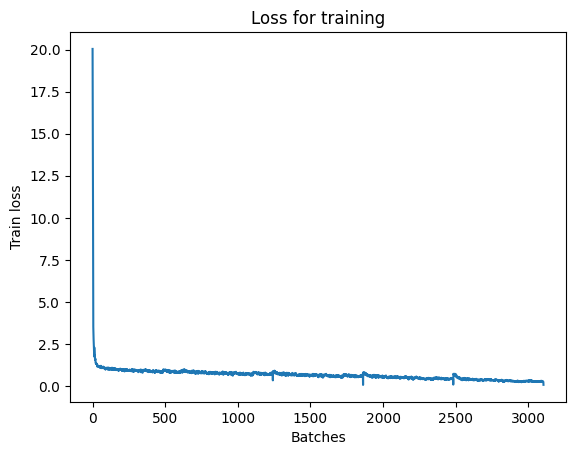

In [13]:
####### Plot the loss
plt.plot(losses)
plt.title("Loss for training")
plt.xlabel("Batches")
plt.ylabel("Train loss")

**قسمت د**

In [14]:
############‌ Examining on test

with torch.no_grad():

  for inputs, attention, labels in test_dl:

      model=model.to(device)
      i=i+1
      inputs=inputs.to(device)
      attention=attention.to(device)
      labels=labels.to(device)

      outputs = model(inputs.to(torch.long), attention_mask=attention, labels=inputs.to(torch.long))

      # Calculate Perplexity loss which is exp of cross entropy between generated textes and second couplets

      loss = F.cross_entropy(outputs.logits.view(-1, outputs.logits.size(-1)), labels.view(-1))
      perplexity = torch.exp(loss)

      if i % 20 == 0:

          input_sentence= tokenizer.batch_decode(inputs[0].to('cpu'), skip_special_tokens=True)
          model.eval()
          test_dat = tokenizer.encode_plus(input_sentence,return_tensors='pt',max_length=80).to(device)

          out_model = model.generate(test_dat['input_ids'], do_sample=True, max_length=128, temperature=0.99, num_return_sequences=1, attention_mask=test_dat['attention_mask'])

          print("Real sentence is:\n",input_sentence)
          print("Generated sentence is:\n",[tokenizer.decode(out_model[i],skip_special_tokens=True) for i in range(len(out_model))])
          print("Perplexity:", perplexity.item())



Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['یکی جای بود آن بسان بهشت گلش مشک سارا بد و زر خشت']
Generated sentence is:
 [' چنین هم برم دشت و بر کوههٔ پیل کوس و المقدس']
Perplexity: 9.322721481323242


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['ز ریگ و بیابان وز کوه و شخ دو لشکر برین سان چو مور و ملخ']
Generated sentence is:
 ['ده شه سی هزار همه رزمجوی و جنگ جوی']
Perplexity: 8.304606437683105


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['نشستند در گلشن زرنگار بزرگان پرمایه با شهریار']
Generated sentence is:
 [' بکشت جنگی پلنگ چو آهو که هنگام جنگ کنی شکار']
Perplexity: 9.856953620910645


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['دگر گنج کش خواندندی عروس که آگند کاوس در شهر طوس']
Generated sentence is:
 [' جز این سواران کس پیشکش که دانی تو نام و نشان']
Perplexity: 10.20327377319336


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['که او گفت در بیشهٔ فاسقون یکی گرگ باشد بسان هیون']
Generated sentence is:
 ['ست مر جنگ را بخواند ز بیژن کسی کش بگوید بس']
Perplexity: 10.758378028869629


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['سوی گنبد آذر آرید روی به فرمان پیغمبر راست گوی']
Generated sentence is:
 [' همه رفته باش رایی نخواهم بجایی که با دل آید بفر']
Perplexity: 9.341463088989258


Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Real sentence is:
 ['ازان جادوی پیر بیرون کشید سرش را ز نیمه تن اندر برید']
Generated sentence is:
 [' کوس و بافسون مر او را بدید بزرگان همگروه']
Perplexity: 9.33321762084961


In [15]:
# New Sentences!!
input_sentence1='يوسف گم گشته باز آيد'
input_sentence2='رستم با بدان بنشست'
input_sentence3='افراسياب رستم را فراخواند'
input_sentences=[input_sentence1,input_sentence2,input_sentence3]

for sent in input_sentences:

   model.eval()
   test_dat = tokenizer.encode_plus(sent,return_tensors='pt',max_length=80).to(device)

   out_model = model.generate(test_dat['input_ids'], do_sample=True, max_length=128, temperature=0.99, num_return_sequences=1, attention_mask=test_dat['attention_mask'])

   print("Real sentence is:\n",sent)
   print("Generated sentence is:\n",[tokenizer.decode(out_model[i],skip_special_tokens=True) for i in range(len(out_model))])



Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.


Real sentence is:
 يوسف گم گشته باز آيد
Generated sentence is:
 ['يوسف گم گشته باز آيدٔ به راه و راه']
Real sentence is:
 رستم با بدان بنشست
Generated sentence is:
 ['رستم با بدان بنشست شاهوزد اندر میان گله رهامش']
Real sentence is:
 افراسياب رستم را فراخواند
Generated sentence is:
 ['افراسياب رستم را فراخواند ورا پیش شاه']
